## Serial Crystallography Introduction

<img src="SFX_intro.png" width="700" align="left"/>

## Sample choice

[3WUL](https://www.rcsb.org/structure/3WUL) is a protein structure in PDB (Sugahara et al, 2016, [10.1038/nmeth.3172](https://dx.doi.org/10.1038/nmeth.3172)).
The protein is hen's egg-white lysozyme (HEWL), a small enzyme commonly used as a test case for X-ray crystallography.

<img src="3wul.pdb1-500.jpg" width="300" align="left"/>

## Detector

The AGIPD detector, which is already in use at the SPB experiment, consists of 16 modules of 512×128 pixels each. Each module is further divided into 8 ASICs (application-specific integrated circuit).

<img src="AGIPD.png" width="300" align="left"/> <img src="agipd_geometry_14_1.png" width="420" align="right"/> 

<div style="clear: both"><small>Photo © European XFEL</small></div>

## Simulation Demonstration

In [1]:
import os,shutil
import h5py
from h5glance import H5Glance
import matplotlib.pyplot as plt
import numpy as np

from SimEx import *

import matplotlib.colors as colors

initializing ocelot...



## Data path setup

In [2]:
data_path = './diffr'

Clean up any data from a previous run:

In [3]:
if os.path.isdir(data_path):
    shutil.rmtree(data_path)

if os.path.isfile(data_path + '.h5'):
    os.remove(data_path + '.h5')

## Set up X-ray Beam Parameters

In [4]:
beamParam = PhotonBeamParameters(
    photon_energy = 4972.0 * electronvolt,  # photon energy in eV
    beam_diameter_fwhm=130e-9 * meter,      # focus diameter in m
    pulse_energy=45e-3 * joule,             # pulse energy in J
    photon_energy_relative_bandwidth=0.003, # relative bandwidth dE/E
    divergence=0.0 * radian,                # Beam divergence in rad
    photon_energy_spectrum_type='tophat',   # Spectrum type. Acceptable values are "tophat", "SASE", and "twocolor")
)

## Detector Setting

In [5]:
from extra_geom import AGIPD_1MGeometry
geom = AGIPD_1MGeometry.from_quad_positions(quad_pos=[
    (-525, 625),
    (-550, -10),
    (520, -160),
    (542.5, 475),
])

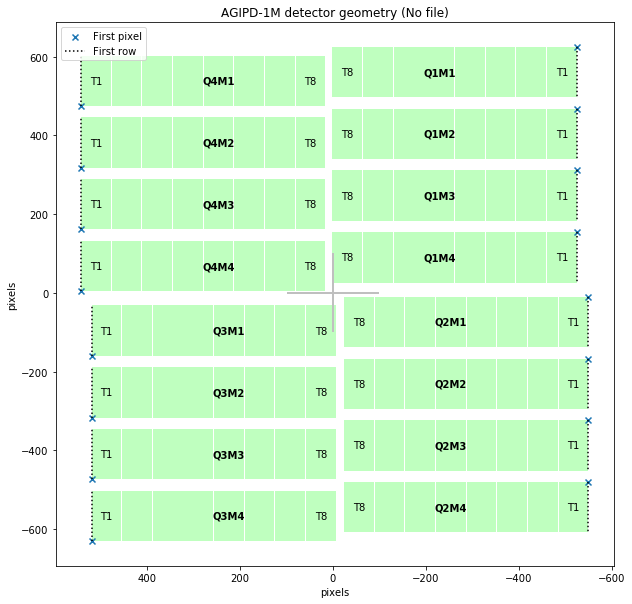

In [6]:
geom.inspect()

In [7]:
geom_file = 'agipd_simple_2d.geom'
geom.write_crystfel_geom(
    geom_file,
    dims=('frame', 'ss', 'fs'),
    adu_per_ev=1.0,
    clen=0.13,          # Sample - detector distance in m
    photon_energy=4972, # eV
    data_path='/data/data',
)

## Diffractor Settings

In [8]:
diffParam = CrystFELPhotonDiffractorParameters(
    sample='3WUL.pdb',                    # Looks up pdb file in cwd, if not found, queries from RCSB pdb mirror.
    uniform_rotation=True,                # Apply random rotation
    number_of_diffraction_patterns=2,     #
    powder=False,                         # Set xto True to create a virtual powder diffraction pattern (unested)
    intensities_file=None,                # File that contains reflection intensities. If set to none, use uniform intensity distribution
    crystal_size_range=[1e-7,1e-7],       # Range ([min,max]) in units of metres of crystal size.
    poissonize=False,                     # Set to True to add Poisson noise.
    number_of_background_photons=0,       # Change number to add uniformly distributed background photons.
    suppress_fringes=False,               # Set to True to suppress side maxima between reflection peaks.
    beam_parameters=beamParam,                 # Beam parameters object from above
    detector_geometry=geom_file,      # External file that contains the detector geometry in CrystFEL notation.
)

In [9]:
diffractor = CrystFELPhotonDiffractor(
    parameters=diffParam, output_path=data_path
)

In [10]:
# Ensure that pattern_sim from CrystFEL is on PATH
import modules
modules.load('crystfel')

diffractor._run_geom()
diffractor.saveH5_geom()

Renaming diffr_out-1.h5 to diffr_out_0000001.h5.
Renaming diffr_out-2.h5 to diffr_out_0000002.h5.
Linking all patterns into /home/kluyvert/Code/crystalProject/src/controller/panoscDEMO/diffr.h5.


11.029121 29832.0 0.0


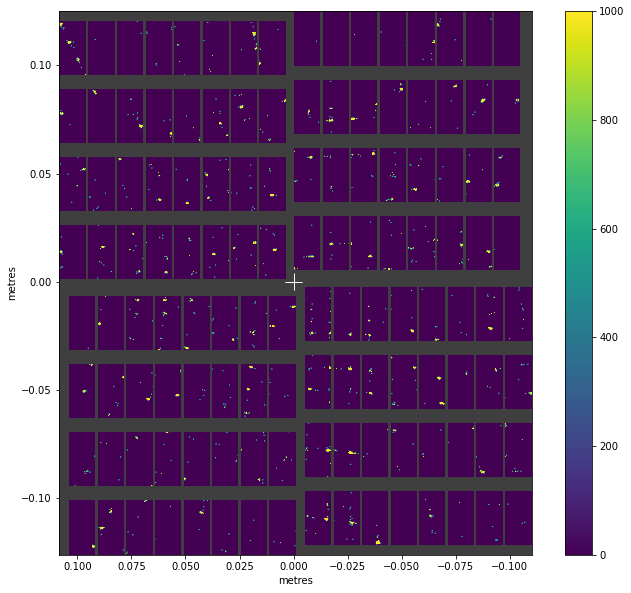

In [11]:
from extra_geom import AGIPD_1MGeometry
geom = AGIPD_1MGeometry.from_crystfel_geom(geom_file)
data_f = h5py.File(data_path+'.h5')
first_iter = next(x for x in data_f['data'])
frame = data_f['data'][first_iter]['data'][...].reshape(16, 512, 128)
fig, ax = plt.subplots(figsize=(12, 10))
geom.plot_data_fast(frame, axis_units='m', ax=ax, vmax=1000);
print (frame.mean(),frame.max(),frame.min())